# FVGP Single Task Notebook
In this notebook we will go through a few features of fvGP. We will be primarily concerned with regression over a single dimension output and single task. See the multiple_task_test_notebook.ipynb for single dimension and multiple task example. The extension to multiple dimensions is straight forward.

## Import fvgp and relevant libraries

In [1]:
import fvgp
from fvgp import gp
import numpy as np
import matplotlib.pyplot as plt

## Defining some input data and testing points

In [2]:
def function(x):
    return np.sin(1.1 * x)+np.cos(0.5 * x)
x_data = np.linspace(-2*np.pi, 10*np.pi,50).reshape(-1,1)
y_data = function(x_data)
x_pred = np.linspace(-2*np.pi, 10 * np.pi, 1000)

## Setting up the fvgp single task object
NOTE: The input data need to be given in the form (N x input_space_dim). The output can either be a N array or N x 1 array where N is the number of data points. See help(gp.GP) for more information.

In [3]:
obj = gp.GP(1, x_data,y_data, init_hyperparameters = np.array([10,10]),use_inv = False)

## Training our gaussian process regression on given data


In [4]:
hyper_param_bounds = np.array([[0.001, 5.],[ 0.001, 100]])
##this will block the main thread, even if you use "hgdl", another option is "global" or "local"
obj.train(hyper_param_bounds, method = "hgdl")

/home/marcus/VirtualEnvironments/fvgp/lib/python3.8/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46653 instead
  warnings.warn(
/home/marcus/VirtualEnvironments/fvgp/lib/python3.8/site-packages/scipy/optimize/_minimize.py:548: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/home/marcus/VirtualEnvironments/fvgp/lib/python3.8/site-packages/scipy/optimize/_minimize.py:548: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/home/marcus/VirtualEnvironments/fvgp/lib/python3.8/site-packages/scipy/optimize/_minimize.py:548: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


## Looking the posterior mean at the test points

In [5]:
post_mean= obj.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
post_var= obj.posterior_covariance(x_pred.reshape(-1,1))["v(x)"]

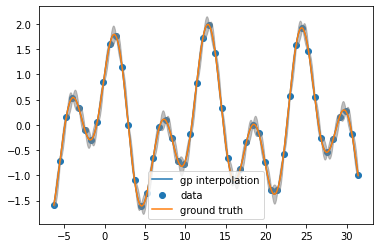

In [6]:
plt.plot(x_pred, post_mean, label='gp interpolation')
plt.scatter(x_data, y_data, label='data')
plt.plot(x_pred,function(x_pred), label = 'ground truth')
plt.fill_between(x_pred, post_mean + 3.0 *np.sqrt(post_var),post_mean - 3.0 * np.sqrt(post_var), color = 'grey', alpha = 0.5)
plt.legend()

# Training Asynchronously 

In [7]:
obj = gp.GP(1, x_data,y_data, init_hyperparameters = np.array([10,10]),
                            variances = np.zeros(y_data.reshape(-1,1).shape))


In [8]:
hyper_param_bounds = np.array([[0.0001, 100], [ 0.0001, 100]])

In [9]:
async_obj = obj.train_async(hyper_param_bounds)

/home/marcus/VirtualEnvironments/fvgp/lib/python3.8/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43505 instead
  warnings.warn(


## Updating asynchronously
Updates hyperparameters to current optimization values

In [10]:
obj.update_hyperparameters(async_obj)

array([10, 10])

## Killing training 


In [11]:
obj.kill_training(async_obj)

## Looking at the posterior mean at the test points

In [12]:
post_mean= obj.posterior_mean(x_pred.reshape(-1,1))['f(x)']

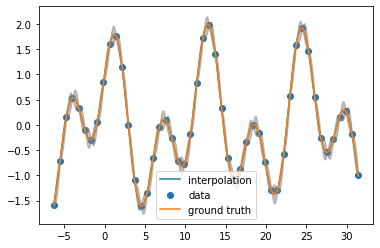

In [13]:
plt.plot(x_pred, post_mean, label='interpolation')
plt.scatter(x_data, y_data, label='data')
plt.plot(x_pred, function(x_pred), label='ground truth')
plt.fill_between(x_pred, post_mean + 3.0 *np.sqrt(post_var),post_mean - 3.0 * np.sqrt(post_var), color = 'grey', alpha = 0.5)
plt.legend()

# Custom Kernels

In [14]:
def kernel_l1(x1,x2, hp, obj):
    ################################################################
    ###standard anisotropic kernel in an input space with l1########
    ################################################################
    d1 = abs(np.subtract.outer(x1[:,0],x2[:,0])) 
    return hp[0] * np.exp(-d1/hp[1])

In [15]:
obj = gp.GP(1, x_data,y_data,
                init_hyperparameters = np.array([10,10]),
                variances = np.zeros(y_data.shape),
                gp_kernel_function = kernel_l1)

## Training our gaussian process regression on given data


In [16]:
hyper_param_bounds = np.array([[0.0001, 1000],[ 0.0001, 1000]])
obj.train(hyper_param_bounds)

## Looking the posterior mean at the test points

In [17]:
post_mean= obj.posterior_mean(x_pred.reshape(-1,1))["f(x)"]

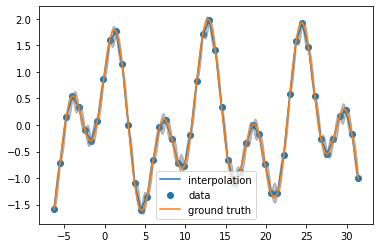

In [18]:
plt.plot(x_pred, post_mean, label='interpolation')
plt.scatter(x_data, y_data, label='data')
plt.plot(x_pred, function(x_pred), label='ground truth')
plt.fill_between(x_pred, post_mean + 3.0 *np.sqrt(post_var),post_mean - 3.0 * np.sqrt(post_var), color = 'grey', alpha = 0.5)
plt.legend()

# Prior Mean Functions
### NOTE: The prior mean function must return a 1d vector, e.g., (100,)

In [19]:
def example_mean(x,hyperparameters,gp_obj):
    return np.ones(len(x))

In [20]:
obj = gp.GP(1, x_data,y_data,init_hyperparameters = np.array([10,10]),
                            variances = np.zeros(y_data.shape),
                            gp_mean_function = example_mean)

## Training our gaussian process regression on given data


In [21]:
hyper_param_bounds = np.array([[0.0001, 1000],[ 0.0001, 1000]])
obj.train(hyper_param_bounds)

## Looking the posterior mean at the test points

In [22]:
post_mean= obj.posterior_mean(x_pred.reshape(-1,1))["f(x)"]

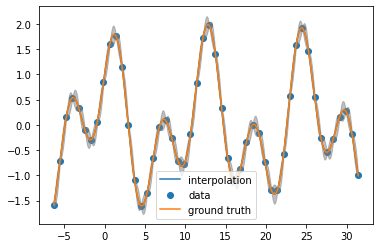

In [23]:
plt.plot(x_pred, post_mean, label='interpolation')
plt.scatter(x_data, y_data, label='data')
plt.plot(x_pred, function(x_pred), label='ground truth')
plt.fill_between(x_pred, post_mean + 3.0 *np.sqrt(post_var),post_mean - 3.0 * np.sqrt(post_var), color = 'grey', alpha = 0.5)
plt.legend()